<a href="https://colab.research.google.com/github/HealLink/ML-Model/blob/ryan's-experiment/notebook_bert_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"
!pip install pydot

In [22]:
# Import-import
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import json

import pydot

tf.get_logger().setLevel('ERROR')

In [2]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

Running in Colab


In [4]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

Mounted at /content/drive


# Step 1: Data cleaning

In [ ]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

--2024-11-24 00:11:00--  https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh
Resolving drive.google.com (drive.google.com)... 142.251.31.100, 142.251.31.138, 142.251.31.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.31.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download [following]
--2024-11-24 00:11:01--  https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.153.132, 2a00:1450:4013:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.153.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31469558 (30M) [application/octet-stream]
Saving to: ‘drive/MyDrive/data/combined_data.csv’

drive/MyDrive/data/ 100%[===============

In [ ]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [ ]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Step 1a: Basic cleaning

In [ ]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    362
status         0
dtype: int64
Number of duplicate rows: 1969


In [ ]:
# Drop rows that contain empty values
df = df.dropna()

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [ ]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    0
status       0
dtype: int64
Number of duplicate rows: 0


### Step 1b: Deep cleaning

In [ ]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [ ]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
def clean_text(text):
    text = text.lower()
    # remove stopwords
    # for word in stopwords:
    #     if word[0] == "'":
    #         text = re.sub(rf"{word}\b", "", text)
    #     else:
    #         text = re.sub(rf"\b{word}\b", "", text)

    # text = re.sub(r'[!"“’#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', ' ', text) # remove punctuation mark
    # text = re.sub(emoj, ' ', text) # remove emoji
    # text = re.sub(r'\d+', ' ', text) # remove number
    # text = re.sub(r'(.)\1+', r'\1', text) # remove repeated character
    # text = re.sub(r' [a-z] ', ' ', text) # remove single character
    # text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    return text.strip()

In [ ]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [ ]:
# Data distribution analysis of each label
df.status.value_counts()

,count
status,
Normal,16039
Depression,15087
Suicidal,10641
Anxiety,3617
Bipolar,2501
Stress,2293
Personality disorder,895


In [ ]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [ ]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [ ]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

,count
word_count_range,
1-100,32810
101-200,9571
201-300,4257
301-400,1961
401-500,1029
501-600,544
601-700,314
701-800,192
801-900,120


In [ ]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

<ipython-input-20-006306a9ed15>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)


status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
word_count_range,,,,,,,
1-100,1785,947,6843,15758,353,1426,5698
101-200,992,810,4059,278,257,647,2528
201-300,435,372,1996,3,157,124,1170
301-400,194,164,981,0,59,38,525
401-500,95,99,477,0,32,31,295
501-600,43,48,273,0,13,13,154
601-700,26,23,157,0,11,2,95
701-800,15,11,102,0,4,6,54
801-900,17,15,48,0,4,3,33


In [ ]:
df_export_candidate = df[(df['word_count'] >= 10) & (df['word_count'] <= 1000)].reset_index(drop=True)
df_export_candidate.status.value_counts()

,count
status,
Depression,14687
Suicidal,10328
Normal,8302
Anxiety,3332
Bipolar,2486
Stress,2263
Personality disorder,877


In [ ]:
# Count the number of examples for each label
label_counts = df_export_candidate['status'].value_counts()

# Find the label with the minimum count
min_label = label_counts.idxmin()
min_count = label_counts.min()

print(f"Label with the lowest number of examples: {min_label}")
print(f"Number of examples: {min_count}")

Label with the lowest number of examples: Personality disorder
Number of examples: 877


In [ ]:
df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
df_export_candidate = df_export_candidate.groupby('status').head(min_count)
df_export_candidate.reset_index(drop=True, inplace=True)
df_export_candidate

,statement,status,word_count,word_count_range
0,"okay, i do not even know how to express my fee...",Suicidal,1000,901-1000
1,"honestly, this is my first reddit post. i have...",Suicidal,999,901-1000
2,i have read many posts and have wanted to make...,Suicidal,998,901-1000
3,"well, this is going to be a long read. i have ...",Depression,998,901-1000
4,"first off, i was in there with a guy who staye...",Depression,995,901-1000
...,...,...,...,...
6134,does your avpd come with or co-exist with soci...,Personality disorder,12,1-100
6135,tomorrow is my first day in group therapy wish...,Personality disorder,11,1-100
6136,how many people message you in an average day?...,Personality disorder,11,1-100
6137,who knew omg i'm home. finally a place i bel...,Personality disorder,10,1-100


In [ ]:
df_export_candidate.status.value_counts()

,count
status,
Suicidal,877
Depression,877
Anxiety,877
Stress,877
Bipolar,877
Personality disorder,877
Normal,877


In [ ]:
df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

In [ ]:
df_export_candidate = df_export_candidate.sample(frac=1).reset_index(drop=True)

In [ ]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data.csv', index=False)

# Step 2: Create the model

In [5]:
VOCAB_SIZE = 10000
MAX_LENGTH = 500
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'

In [6]:
# Run this code if you skip step 1. beware, cleaned dataset is not updated regularly
# !wget -O {data_dir+"/cleaned_data.csv"} "https://drive.google.com/uc?export=download&id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY"

sentences = []
labels = []

with open(data_dir+"/cleaned_data.csv", 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

### Step 2a: Create tf.data.Dataset

In [ ]:
# don't run this code if you skip step 1
dataset = tf.data.Dataset.from_tensor_slices((df_export_candidate["statement"].values, df_export_candidate["status"].values))

In [7]:
train_size = int(len(dataset) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = validation_dataset.map(lambda statement, status: statement)
test_labels = validation_dataset.map(lambda statement, status: status)

There are 4771 sentence-label pairs for training.

There are 1193 sentence-label pairs for validation.



### Step 2b: Create label encoder

In [8]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.

    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)

    return label_encoder

# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Suicidal', 'Stress', 'Personality disorder', 'Normal', 'Depression', 'Bipolar', 'Anxiety']


### Step 2c: Dataset preprocessing

In [10]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_label_encoded = tf.data.Dataset.zip(train_statement,train_labels_encoded)
test_dataset_label_encoded = tf.data.Dataset.zip(test_statement,test_labels_encoded)

# Optimize the datasets for training
train_dataset_final = (train_dataset_label_encoded
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_label_encoded
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

Number of batches in the train dataset: 150
Number of batches in the validation dataset: 38


In [11]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32,)
Shape of the validation batch: (32,)


### Step 2d: Architect the model

#### Step 2d-1: Loading model - choose model to fine tune

In [12]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Step 2d-2: Preprocessing model

In [13]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['i wanna die']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1045 10587  3280   102     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Step 2d-3: Using BERT Model

In [14]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9990444   0.8745171  -0.07355936 -0.05372535  0.04194468  0.8999656
  0.9805069  -0.97996026 -0.3581079  -0.9996639   0.1728642  -0.9424376 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.4085594   0.2612027   0.4493124  ... -0.7213608   1.2863595
   0.01147558]
 [ 0.18921873  0.7910987   0.6272204  ... -1.5276443   0.5723879
  -1.0363461 ]
 [ 0.41521192  0.6978401  -0.9479429  ... -0.9111906   0.6550257
   0.24728401]
 ...
 [ 0.17663947  0.39509025 -0.293308   ... -0.11866884  1.129125
  -0.4015114 ]
 [ 0.26331267  0.3228937   0.18425001 ... -0.2108205   1.3253524
  -0.08144247]
 [ 0.24777238  0.2337354   0.1351261  ... -0.27669346  1.2443149
  -0.09410445]]


#### Step 2d-4: Defining model

In [17]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(7, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor(
[[0.26261652 0.07607278 0.03890348 0.11105439 0.11671897 0.19786544
  0.1967684 ]], shape=(1, 7), dtype=float32)


In [24]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset_final).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [25]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [26]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
	classifier_model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = classifier_model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 7)


# Step 3: How To Train Your ~~Dragon~~ ML Model

In [28]:
# Callbacks
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.keras"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "loss": [], "sparse_categorical_accuracy": [],
                        "val_loss": [], "val_sparse_categorical_accuracy": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            # with open(self.epoch_file, 'w') as f:
            #     f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch + 1))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch + 1)
        self.history["loss"].append(logs.get("loss"))
        self.history["sparse_categorical_accuracy"].append(logs.get("sparse_categorical_accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_sparse_categorical_accuracy"].append(logs.get("val_sparse_categorical_accuracy"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [29]:
# run this code to delete checkpoint
try:
    os.remove(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

No saved epoch found


In [31]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    classifier_model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

Resuming training from epoch 11


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'drive/MyDrive/data/checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# num_of_epoch = 100
history = classifier_model.fit(
    train_dataset_final,
    epochs=epochs,
    validation_data=test_dataset_final,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback
    ]
    )

Epoch 1/10
 43/150 [=======>......................] - ETA: 17:50 - loss: 2.2083 - sparse_categorical_accuracy: 0.1599

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

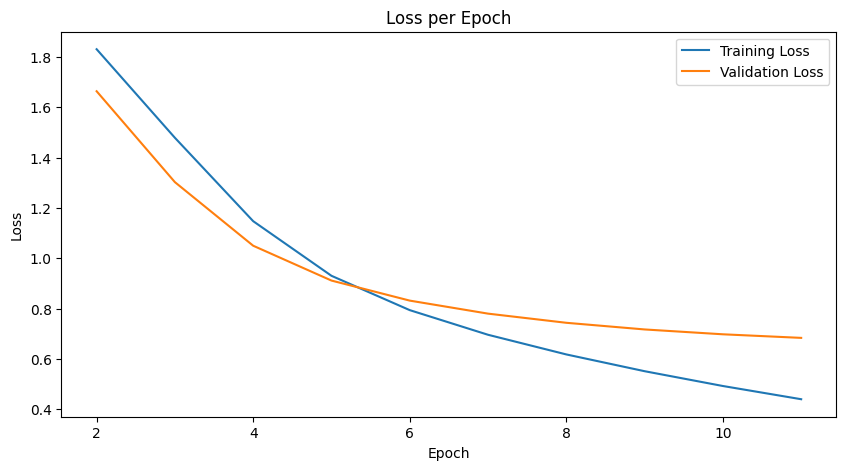

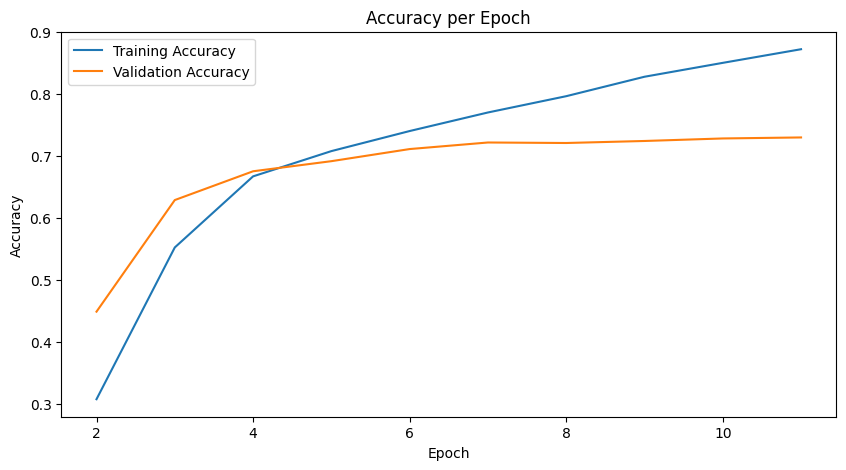

In [ ]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

# Step 4: Test the model

In [ ]:
rawtext_test = ["i'm really nervous"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(tokenizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  47    8   51  233 1195]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 ...
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]], shape=(500, 5), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[[3.1016039e-02 1.6379152e-01 2.3748980e-01 ... 3.1037180e-02
  1.8597090e-01 1.3207725e-01]
 [1.8049697e-03 2.5665307e-02 2.4951806e-02 ... 4.0975236e-05
  7.0504652e-04 2.0696587e-04]
 [1.8049697e-03 2.5665307e-02 2.4951806e-02 ... 4.0975236e-05
  7.0504652e-04 2.0696587e-04]
 ...
 [1.8049699e-03 2.5665309e-02 2.4951806e-02 ... 4.0975236e-05
  7.0504652e-04 2.0696588e-04]
 [1.8049706e-03 2.5665324e-02 2.4951816e-02 ... 4.0975232e-05
  7.0504716e-04 2.0696585e-04]
 [1.8049706e-03 2.5665324e-02 2.4951816e-02 ... 4.0975232e-05
  7.0504710e-04 2.0696584e-04]]
Predicted class: Personality disorder


# Step 5: Done, save the model

In [ ]:
# Run this if you happy with the model
with open(data_dir+"/label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save(data_dir+'/second_iteration.keras')